In [1]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
from os.path import join as pjoin
from scipy.stats.stats import sem
from matplotlib import pyplot as plt
from cxy_visual_dev.lib.predefine import dataset_name2info, proj_dir
from magicbox.algorithm.array import summary_across_col_by_mask
from magicbox.algorithm.plot import prepare_y_bar_line, plot_bar, plot_line

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/line_bar')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

ModuleNotFoundError: No module named 'cxy_visual_dev'

# Plot Decomposition

## 可视化PCA各成分的解释方差

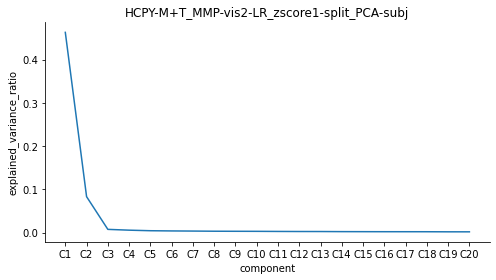

In [6]:
# settings
fname = 'HCPY-M+T_MMP-vis2-LR_zscore1-split_PCA-subj'
components = 'all'
out_file = pjoin(work_dir, f'{fname}.jpg')
out_file = 'show'

# start
data = pkl.load(open(pjoin(anal_dir, f'decomposition/{fname}.pkl'), 'rb'))
if components == 'all':
    components = np.arange(data.n_components) + 1
else:
    components = np.array(components)
plot_line(
    y=data.explained_variance_ratio_[components - 1], n_row=1, n_col=1, figsize=(7, 4),
    yerr=None, x=None, label=None, color=None, mode=out_file, xlabel='component',
    xtick=None, xticklabel=tuple(f'C{i}' for i in components), rotate_xticklabel=False,
    ylabel='explained_variance_ratio', ylim=None, title=fname
)

## 把多个模态同一个成分的权重时间序列画到只有单个ax的fig里（线图）

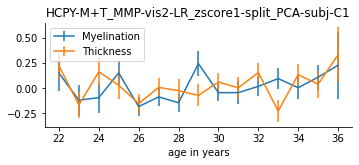

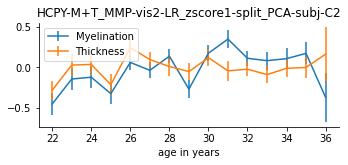

In [12]:
# settings
zscore_flag = True
fnames = [
    'HCPY-M+T_MMP-vis2-LR_zscore1-split_PCA-subj_M.csv',
    'HCPY-M+T_MMP-vis2-LR_zscore1-split_PCA-subj_T.csv'
]
labels = ('Myelination', 'Thickness')
cols = ['C1', 'C2']
key_groups_list = [[['0-C1', '1-C1']], [['0-C2', '1-C2']]]
titles = [
    'HCPY-M+T_MMP-vis2-LR_zscore1-split_PCA-subj-C1',
    'HCPY-M+T_MMP-vis2-LR_zscore1-split_PCA-subj-C2'
]
out_files = [
    pjoin(work_dir, 'HCPY-M+T_MMP-vis2-LR_zscore1-split_PCA-subj-C1.jpg'),
    pjoin(work_dir, 'HCPY-M+T_MMP-vis2-LR_zscore1-split_PCA-subj-C2.jpg')
]
# out_files = ['show', 'show']

age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPY'])[age_name]
ages_uniq = np.unique(ages).tolist()
ages_uniq.remove(37)
ages_uniq = np.array(ages_uniq)

# start
data = []
row_names = []
for f_idx, fname in enumerate(fnames):
    df = pd.read_csv(pjoin(anal_dir, f'decomposition/{fname}'))
    data.append(np.array(df[cols]).T)
    row_names.extend([f'{f_idx}-{col}' for col in cols])
data = np.concatenate(data, 0)
y_dict, yerr_dict = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    tol_size=10, nan_mode=True, row_names=row_names, zscore_flag=zscore_flag, out_dict=True
)
for i, key_groups in enumerate(key_groups_list):
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
    plot_line(y, n_row=1, n_col=1, figsize=(5, 2.4), yerr=yerr, x=ages_uniq,
              label=labels, color=None, mode=out_files[i], xlabel=age_name, xtick=None,
              xticklabel=None, rotate_xticklabel=False, ylabel=None, ylim=None, title=titles[i])

## 把同一个成分多个模态的权重平均大小画到只有单个ax的fig里（bar图）

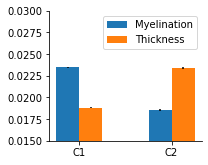

In [3]:
# settings
fnames = [
    'HCPY-M+T_MMP-vis2-LR_zscore1-split_PCA-subj_M.csv',
    'HCPY-M+T_MMP-vis2-LR_zscore1-split_PCA-subj_T.csv'
]
meas = ('Myelination', 'Thickness')
cols = ('C1', 'C2')
ylim = (0.015, 0.03)
# out_file = pjoin(work_dir, 'HCPY-M+T_MMP-vis2-LR_zscore1-split_PCA-subj.jpg')
out_file = 'show'

# start
n_fname = len(fnames)
n_col = len(cols)
y = np.zeros((n_fname, n_col), np.float64)
yerr = np.zeros((n_fname, n_col), np.float64)
for f_idx, fname in enumerate(fnames):
    df = pd.read_csv(pjoin(anal_dir, f'decomposition/{fname}'))
    for col_idx, col in enumerate(cols):
        samples = np.array(df[col])
        samples = np.abs(samples[~np.isnan(samples)])
        y[f_idx, col_idx] = np.mean(samples)
        yerr[f_idx, col_idx] = sem(samples)
plot_bar(
    y, n_row=1, n_col=1, figsize=(3, 2.4), yerr=yerr, x=None, width=None,
    label=meas, color=None, show_height=None, mode=out_file, xlabel=None,
    xticklabel=cols, rotate_xticklabel=False, ylabel=None, ylim=ylim, title=None
)

# Plot Fit

## HCPD-M+T=C1C2.csv

### 现有的column

Warning! The sample size of value-6 is 5.
Warning! The sample size of value-7 is 5.


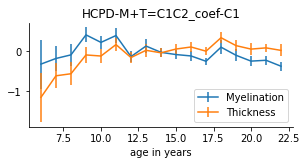

In [5]:
zscore_flag = True
fname = 'HCPD-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPD'])[age_name]
ages_uniq = np.unique(ages)

row_names = ['coef_C1_Myelination', 'coef_C1_Thickness']
title = f'{fname}_coef-C1'
ylabel = None
key_groups = [row_names]
labels = ('Myelination', 'Thickness')

y_dict, yerr_dict = summary_across_col_by_mask(
    data=np.array(df[row_names]).T, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    nan_mode=False, row_names=row_names, zscore_flag=zscore_flag, out_dict=True)
plot_line(
    y=prepare_y_bar_line(y_dict, key_groups), figsize=(4.5, 2.4),
    yerr=prepare_y_bar_line(yerr_dict, key_groups), x=ages_uniq, label=labels,
    xlabel=age_name, ylabel=ylabel, title=title,
    mode=pjoin(work_dir, f'{title}.jpg')
    # mode='show'
)


### (|M|-|T|)/(|M|+|T|)

Warning! The sample size of value-6 is 5.
Warning! The sample size of value-7 is 5.


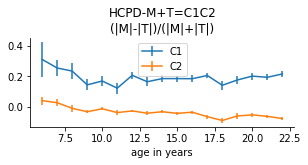

In [18]:
fname = 'HCPD-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPD'])[age_name]
ages_uniq = np.unique(ages)

labels = ('C1', 'C2')
data = np.zeros((len(labels), df.shape[0]), np.float64)
for lbl_idx, lbl in enumerate(labels):
    m = np.abs(df[f'coef_{lbl}_Myelination'])
    t = np.abs(df[f'coef_{lbl}_Thickness'])
    data[lbl_idx, :] =  (m - t) / (m + t)
title = f'{fname}\n(|M|-|T|)/(|M|+|T|)'
out_file = pjoin(work_dir, f'{fname}_MT-diff.jpg')

y, yerr = summary_across_col_by_mask(data, ages, ages_uniq, ['mean', 'sem'])
plot_line(
    y=y, figsize=(4.5, 2.4), yerr=yerr, x=ages_uniq,
    label=labels, xlabel=age_name, ylabel=None, title=title,
    mode=out_file
    # mode='show'
)


### |M|-|T|

Warning! The sample size of value-6 is 5.
Warning! The sample size of value-7 is 5.


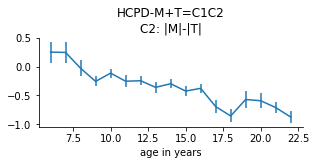

In [23]:
fname = 'HCPD-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPD'])[age_name]
ages_uniq = np.unique(ages)

lbl = 'C2'
data = np.zeros((1, df.shape[0]), np.float64)
m = np.abs(df[f'coef_{lbl}_Myelination'])
t = np.abs(df[f'coef_{lbl}_Thickness'])
data[0, :] =  m - t
title = f'{fname}\n{lbl}: |M|-|T|'
out_file = pjoin(work_dir, f'{fname}_MT-diff-{lbl}.jpg')

y, yerr = summary_across_col_by_mask(data, ages, ages_uniq, ['mean', 'sem'])
plot_line(
    y=y, figsize=(4.5, 2.4), yerr=yerr, x=ages_uniq, xlabel=age_name,
    title=title, mode=out_file
)

## CalcS+OcPole+MT=C1.csv

score: 0.5729106197006566


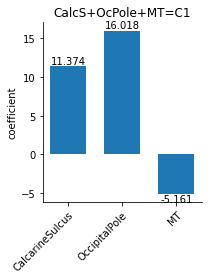

In [3]:
fname = 'CalcS+OcPole+MT=C1'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))
print('score:', df['score_C1'].item())
out_file = pjoin(work_dir, f'{fname}.jpg')

coef_names = [i for i in df.columns if i.startswith('coef_C1_')]
feat_names = tuple(i.split('_')[-1] for i in coef_names)
plot_bar(y=np.array(df.loc[0, coef_names]), figsize=(3, 4), show_height='.3f',
         xticklabel=feat_names, rotate_xticklabel=True, ylabel='coefficient',
         title=fname, mode='show')